In [6]:
import os, sys, inspect

cmd_folder = os.path.realpath(
    os.path.dirname(
        os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0])))

if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)
    
from transitions import *
from transitions.extensions import GraphMachine as MGraph
from IPython.display import Image, display, display_png

class Matter(object):
    def is_valid(self):
        return True
    
    def is_not_valid(self):
        return False
    
    def is_also_valid(self):
        return True

# Mixin the graph
class MyGraphMachine(MGraph, Machine):
    def __init__(self, *args, **kwargs):
        super(MyGraphMachine, self).__init__(*args, **kwargs)

    def show_graph(self):
        self.graph.draw('state.png', prog='dot')
        display(Image('state.png'))        

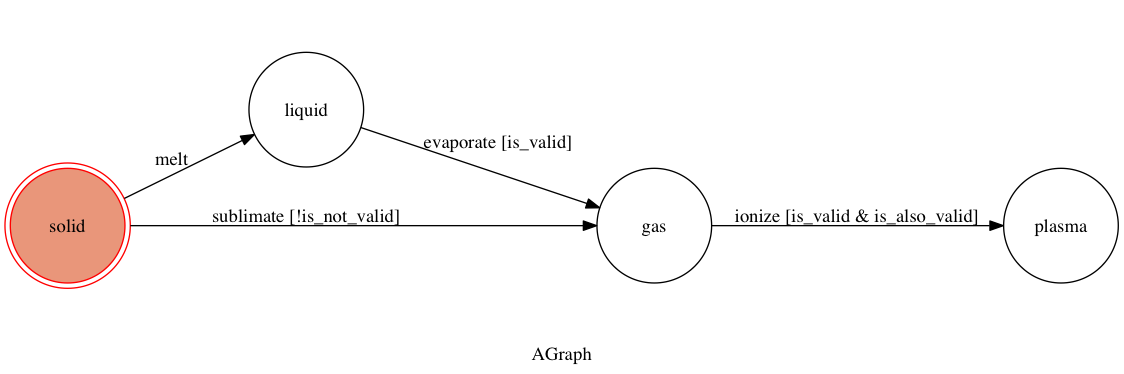

In [7]:
transitions = [
    { 'trigger': 'melt', 'source': 'solid', 'dest': 'liquid' },
    { 'trigger': 'evaporate', 'source': 'liquid', 'dest': 'gas', 'conditions':'is_valid' },
    { 'trigger': 'sublimate', 'source': 'solid', 'dest': 'gas', 'unless':'is_not_valid' },
    { 'trigger': 'ionize', 'source': 'gas', 'dest': 'plasma', 
      'conditions':['is_valid','is_also_valid'] }
]
states=['solid', 'liquid', 'gas', 'plasma']

machine = MyGraphMachine(model=Matter(), 
                         states=states, 
                         transitions=transitions, 
                         auto_transitions=False, 
                         initial='solid', 
                         title="Matter is Fun!",
                         show_conditions=True)
machine.show_graph()

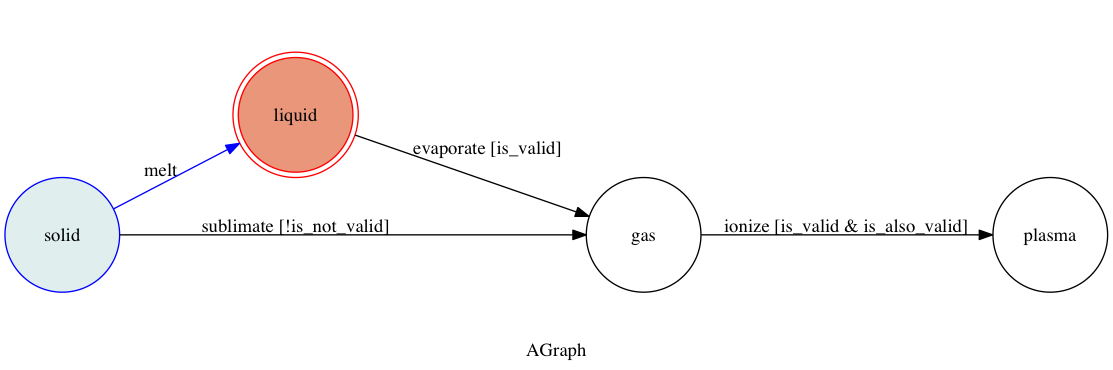

In [8]:
machine.model.melt()
machine.show_graph()

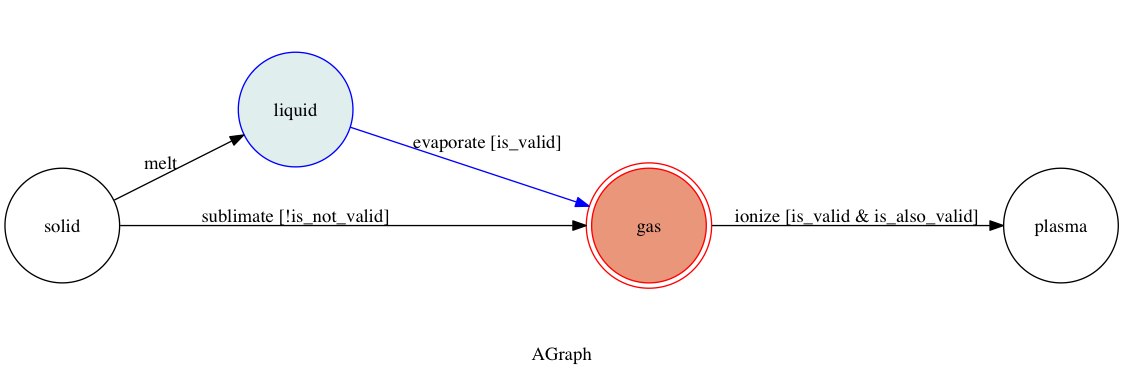

In [9]:
machine.model.evaporate()
machine.show_graph()

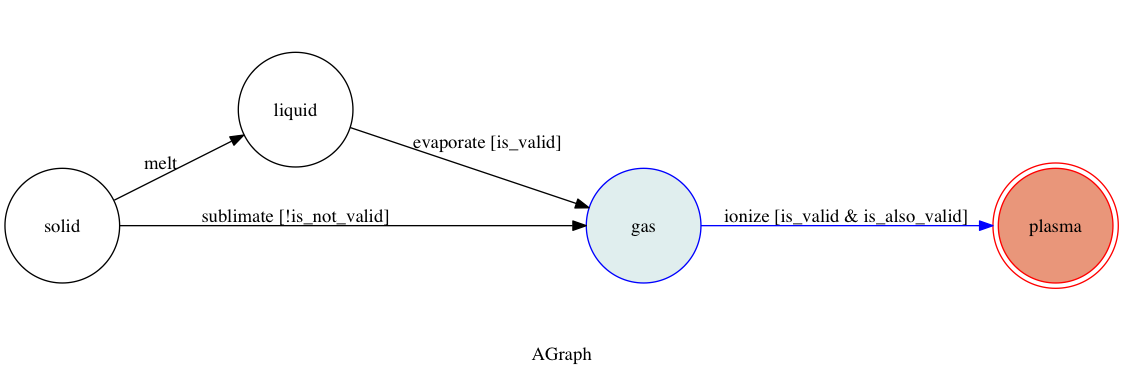

In [10]:
machine.model.ionize()
machine.show_graph()